# Basic Seq2Seq for Twitter Customer Support

In this assignment, we'll try to build a seq2seq chatbot that can mimic a customer support officer (how cool?!). The task we'll train it on is predicting company responses to consumers. The dataset we will use can be downloaded [here](https://chula-dl-class.s3-ap-southeast-1.amazonaws.com/customer-support-on-twitter.zip). 

Note that we'll only work on single-turn conversation, i.e. the response only depends on the most recent message from the customer. The multi-turn diaglog system is a much harder research problem and even the state-of-the-art models struggle to get it right. Therefore, it's not covered in this assignment.

This notebook lets you prepare the data and construct a basic LSTM model in Keras. After a couple of hours of training on a GPU, your loss should get below 1.3 and the model starts to give sensible replies. To converge might take a bit longer depends on the complexity of your model.

![seq2seq model architecture](https://i.imgur.com/JmuryKu.png)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# installation. only run once
!pip install langdetect
!pip install sentencepiece

  Created wheel for langdetect: filename=langdetect-1.0.7-cp37-none-any.whl size=993467 sha256=0d8b87bfa7a807ca7ebe89d67d0dbb578f1b3a9218b4da098fadea5f881879b3
  Stored in directory: C:\Users\ROG\AppData\Local\pip\Cache\wheels\ec\0c\a9\1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect


In [0]:
import re
import random
import time

print('Library versions:')

import tensorflow.keras as keras
print(f'keras:{keras.__version__}')
import pandas as pd
print(f'pandas:{pd.__version__}')
import numpy as np
print(f'numpy:{np.__version__}')

Library versions:
keras:2.2.4-tf
pandas:0.25.1
numpy:1.16.5


## Model Parameters

In [0]:
DATA_FOLDER = 'C:/Users/ROG/Desktop/data/customer-support-on-twitter/twcs/'
#DATA_FOLDER = '/Users/admin/OneDrive - KNOREX/DL Class/'

In [0]:
# 4096 - large enough for demonstration, larger values make network training slower
VOCAB_SIZE = 2**12
# seq2seq generally relies on fixed length message vectors - longer messages provide more info
# but result in slower training and larger networks
MAX_MESSAGE_LEN = 50  
# Embedding size for words - gives a trade off between expressivity of words and network size
EMBEDDING_SIZE = 128
# Embedding size for whole messages, same trade off as word embeddings
CONTEXT_SIZE = 256
# Larger batch sizes generally reach the average response faster, but small batch sizes are
# required for the model to learn nuanced responses.  Also, GPU memory limits max batch size.
bs = 32
# Helps regularize network and prevent overfitting.
DROPOUT = 0.2
# High learning rate helps model reach average response faster, but can make it hard to 
# converge on nuanced responses
LEARNING_RATE=0.005

# Tokens needed for seq2seq
PAD = 1  # after message has finished, this fills all remaining vector positions
START = 2  # provided to the model at position 0 for every response predicted
END = 3  # token that marks the end of the sequence

## Data Preparation
### Data Loading and Reshaping

Your first task is to extract the pairs of conversation from the input csv file. It has a column named `in_response_to_tweet_id`, which you can join with the `tweet_id` column to find pairs of conversations. Note that the original conversation is multi-turn. We want to extract the single-turn conversations where the first utterance is from the customer and the second one is from the company. E.g.: 

* customer: Hi Air Asia, I have a complaint! (1)
* AirAsia: Sorry to hear that, can you provide more details (2)
* customer: My flight got delayed for 12 hours! (3)
* AirAsia: We apologize for that. We'll refund you in full. (4)
* customer: Thanks! :) (5)

So you shall extract the x, y pairs (1,2) and (3,4). Note that (5) is ignored since there's no reply from the company for it.

In [0]:
%%time
tweets = pd.read_csv(DATA_FOLDER + 'twcs.csv')
tweets = tweets.fillna(-1).astype({'in_response_to_tweet_id':'int32'})

Wall time: 8.36 s


In [0]:
print('Total messages:', tweets.shape[0])
tweets.head()

Total messages: 2811774


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,-1,1
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6


In [0]:
# TODO: get the outbound messages which response to some user query. Hint, a simple pandas filter will do.
outbounds=tweets.query('inbound==`False`')
inbounds=tweets.query('inbound==`True`')

In [0]:
print('Total replies:', outbounds.shape[0])
outbounds.head()

Total replies: 1273931


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,-1,12
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,@115713 We understand your concerns and we'd l...,12,16


In [0]:
print('Total replies:', outbounds.shape[0])
inbounds.head()

Total replies: 1273931


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,-1,1
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",-1
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15


In [0]:
inbounds_and_outbounds = tweets.merge(outbounds, left_on='tweet_id', right_on='in_response_to_tweet_id')
inbounds_and_outbounds.head(10)

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3
1,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",-1,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8
3,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",-1,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,-1,8
4,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",-1,10,sprintcare,False,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...,-1,8
5,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,-1,12
6,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15,13,sprintcare,False,Wed Nov 01 20:48:14 +0000 2017,@115713 I would really like to work with you t...,-1,12
7,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15,14,sprintcare,False,Wed Nov 01 20:47:40 +0000 2017,"@115713 Hi, my name is Shantel, I'm a resoluti...",-1,12
8,16,115713,True,Tue Oct 31 20:00:43 +0000 2017,@sprintcare Since I signed up with you....Sinc...,15,17,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,@115713 We understand your concerns and we'd l...,12,16
9,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,-1,17,sprintcare,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18


In [0]:
# TODO: join the conversation together with x as the user query and y as the company's response. Also randomize the data
# Hint: 1. you can use pandas.merge with the correct id column. 2. you can use pandas.sample with frac=1 to randomize the data
inbounds_and_outbounds = inbounds_and_outbounds.sample(frac =1)
inbounds_and_outbounds.head(5)

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
1128951,2670651,752079,True,Sun Nov 19 10:09:10 +0000 2017,Stuck on a @VirginAtlantic plane at Gatwick be...,2670649,-1,2670649,VirginAtlantic,False,Sun Nov 19 10:17:11 +0000 2017,@752079 Sorry to hear that Brian. Which flight...,2670650,2670651
1224025,2891678,801590,True,Tue Nov 28 04:00:48 +0000 2017,@116035: There is a payment I made to Green Mo...,"2891677,2891679",-1,2891677,BofA_Help,False,Tue Nov 28 14:36:15 +0000 2017,@801590 Pls click below to DM your name/ZIP/ph...,-1,2891678
792064,1888285,563141,True,Mon Oct 23 15:07:24 +0000 2017,@AppleSupport fix this restarting problem plea...,1888283,-1,1888283,AppleSupport,False,Mon Oct 23 15:36:00 +0000 2017,@563141 Send us a DM and tell us what issues y...,1888284,1888285
657724,1573478,131957,True,Mon Oct 16 22:22:48 +0000 2017,@GWRHelp Will you consider pre booked seats on...,"1573476,1573494",-1,1573476,GWRHelp,False,Tue Oct 17 06:18:12 +0000 2017,@131957 Hi there. Can you please explain what ...,1573477,1573478
1094823,2592594,734240,True,Fri Nov 17 01:52:34 +0000 2017,@idea_cares why is it compulsory to recharge w...,"2592593,2592595",-1,2592593,idea_cares,False,Fri Nov 17 01:58:01 +0000 2017,@734240 We would request you to share your ide...,-1,2592594


In [0]:
# tqdm().pandas()  # Enable tracking of progress in dataframe `apply` calls
print('Conversation turns:', inbounds_and_outbounds.shape[0])
inbounds_and_outbounds.head()

Conversation turns: 1265281


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
1128951,2670651,752079,True,Sun Nov 19 10:09:10 +0000 2017,Stuck on a @VirginAtlantic plane at Gatwick be...,2670649,-1,2670649,VirginAtlantic,False,Sun Nov 19 10:17:11 +0000 2017,@752079 Sorry to hear that Brian. Which flight...,2670650,2670651
1224025,2891678,801590,True,Tue Nov 28 04:00:48 +0000 2017,@116035: There is a payment I made to Green Mo...,"2891677,2891679",-1,2891677,BofA_Help,False,Tue Nov 28 14:36:15 +0000 2017,@801590 Pls click below to DM your name/ZIP/ph...,-1,2891678
792064,1888285,563141,True,Mon Oct 23 15:07:24 +0000 2017,@AppleSupport fix this restarting problem plea...,1888283,-1,1888283,AppleSupport,False,Mon Oct 23 15:36:00 +0000 2017,@563141 Send us a DM and tell us what issues y...,1888284,1888285
657724,1573478,131957,True,Mon Oct 16 22:22:48 +0000 2017,@GWRHelp Will you consider pre booked seats on...,"1573476,1573494",-1,1573476,GWRHelp,False,Tue Oct 17 06:18:12 +0000 2017,@131957 Hi there. Can you please explain what ...,1573477,1573478
1094823,2592594,734240,True,Fri Nov 17 01:52:34 +0000 2017,@idea_cares why is it compulsory to recharge w...,"2592593,2592595",-1,2592593,idea_cares,False,Fri Nov 17 01:58:01 +0000 2017,@734240 We would request you to share your ide...,-1,2592594


In [0]:
inbounds_and_outbounds.to_csv(DATA_FOLDER + 'tweets_conversations.csv', index=False, columns=['text_x', 'text_y', 'author_id_y'])

### Preprocessing

In [0]:
inbounds_and_outbounds = pd.read_csv(DATA_FOLDER + 'tweets_conversations.csv', lineterminator='\n')

In [0]:
inbounds_and_outbounds.head()

,text_x,text_y,author_id_y\r
0,Stuck on a @VirginAtlantic plane at Gatwick be...,@752079 Sorry to hear that Brian. Which flight...,VirginAtlantic\r
1,@116035: There is a payment I made to Green Mo...,@801590 Pls click below to DM your name/ZIP/ph...,BofA_Help\r
2,@AppleSupport fix this restarting problem plea...,@563141 Send us a DM and tell us what issues y...,AppleSupport\r
3,@GWRHelp Will you consider pre booked seats on...,@131957 Hi there. Can you please explain what ...,GWRHelp\r
4,@idea_cares why is it compulsory to recharge w...,@734240 We would request you to share your ide...,idea_cares\r


#### 1. Data cleaning

Cleaning up the data reduces the noise and the vocabulary size, which is critical to make sure you train a highly accurate model. I recommend doing the following data cleaning steps (feel free to add other steps).

1. Filter out non-English tweets such as:


| Inbound | Outbound |
| -----| ------|
|@115798 อยากทราบว่า ผู้สูงอายุ ที่มีโรคประจำตัว สามารถขึ้นเครื่องได้หรือป่าว | "@420634 Hi, kindly tweet us in English or you may contact Thailand Call Centre +66 2 515 9999 for further assistance. Thanks - Ed"|

This can be done using a language detection library, such as https://pypi.org/project/langdetect/. For simplicity, you can concatenate the inbound and outbound message and pass to the model to predict. Removing other languages helps us to reduce the unnecessary vocabulary. Since they don't have enough data, we can't build a good chatbot for these languages anyway.

2. Replace all screen names like `@12343` with `@__sn__`. My conjecture is that keep the screen name of the company (e.g. `@SW_Help`) may help since each company may respond differently.

3. Remove all the non-ascii characters (e.g. emojis 🤥 💯,🔥).

4. Lowercase all tweets. The captalization in informal text is noisy anyway and they don't prevent from understanding

5. Replace all the URLs with a <URL> token.
    
6. Remove all hashtags, since they are often out of context.

In [0]:
%%time
tqdm().pandas()
from tqdm import tqdm_notebook as tqdm
# TODO: filter out none English content
# Note: it takes around 1hr to filter all the data in the corpus. 
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
# i =0
# for index, row in tqdm(inbounds_and_outbounds.iterrows()):
#     try :
#         check = detect(row['text_x'])
#     except :
#         inbounds_and_outbounds.drop(index)
# #         print(row['text_x'])
#         continue
# #     if i == 10 :
# #         break
#     if check!='en':
# #         print(row['text_x'])
#         inbounds_and_outbounds.drop(index)
# #         print("dropped")
# #     i+=1    

def detect_lang(query):
    try:
        lang = detect(query)
    except LangDetectException:
        lang = None
    return lang

df_en = inbounds_and_outbounds.copy()
df_en = df_en[df_en.text_x.progress_apply(lambda x : detect_lang(x))=='en']
df_en = df_en[df_en.text_y.progress_apply(lambda x : detect_lang(x))=='en']


Wall time: 2h 35min 55s


In [0]:
df_en.to_csv(DATA_FOLDER + 'tweets_conversations_en.csv', index=False)

In [0]:
df_en = pd.read_csv(DATA_FOLDER + 'tweets_conversations_en.csv', lineterminator='\n')

In [0]:
!pip install emoji

  Created wheel for emoji: filename=emoji-0.5.4-cp37-none-any.whl size=42181 sha256=5ca69b9c5fccb3b18b057d24326d9b11a45328e72b73a2cc49eae9ef5f57f085
  Stored in directory: C:\Users\ROG\AppData\Local\pip\Cache\wheels\2a\a9\0a\4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [0]:
%%time
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm
import emoji
tqdm().pandas()
import dill
# TODO: remove all the non-ascii characters
# Hint, keep the data in place in pandas with df.[column].apply with a lambda function will be handy for such preprocessing steps.
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

def remove_emoji_1(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_emoji_2(string):
    return emoji.get_emoji_regexp().sub(u'', string)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)



df_rm_emo = df_en.copy()
df_rm_emo.text_x=df_rm_emo.text_x.progress_apply(lambda x : remove_emoji_1(x))
df_rm_emo.text_y=df_rm_emo.text_y.progress_apply(lambda x : remove_emoji_1(x))


df_rm_emo.text_x=df_rm_emo.text_x.progress_apply(lambda x : remove_emoji_2(x))
df_rm_emo.text_y=df_rm_emo.text_y.progress_apply(lambda x : remove_emoji_2(x))

df_rm_emo.text_x=df_rm_emo.text_x.progress_apply(lambda x : remove_emoticons(x))
df_rm_emo.text_y=df_rm_emo.text_y.progress_apply(lambda x : remove_emoticons(x))



Wall time: 20min 13s


In [0]:
df_rm_emo.to_csv(DATA_FOLDER + 'tweets_conversations_en_rm_emo.csv', index=False)

In [0]:
df_rm_emo = pd.read_csv(DATA_FOLDER + 'tweets_conversations_en_rm_emo.csv', lineterminator='\n')

In [0]:
%%time

# TODO: Replace anonymized screen names with common token @__sn__
df_rp_name = df_rm_emo.copy()
df_rp_name['text_x'] = df_rp_name['text_x'].str.replace('@\d+', '@__sn__')
df_rp_name['text_y'] = df_rp_name['text_y'].str.replace('@\d+', '@__sn__')

Wall time: 2.7 s


In [0]:
df_rp_name.head(20)

,text_x,text_y,author_id_y\r\r\r
0,Stuck on a @VirginAtlantic plane at Gatwick be...,@__sn__ Sorry to hear that Brian. Which flight...,VirginAtlantic\r\r\r
1,@__sn__: There is a payment I made to Green Mo...,@__sn__ Pls click below to DM your name/ZIP/ph...,BofA_Help\r\r\r
2,@AppleSupport fix this restarting problem plea...,@__sn__ Send us a DM and tell us what issues y...,AppleSupport\r\r\r
3,@GWRHelp Will you consider pre booked seats on...,@__sn__ Hi there. Can you please explain what ...,GWRHelp\r\r\r
4,@idea_cares why is it compulsory to recharge w...,@__sn__ We would request you to share your ide...,idea_cares\r\r\r
5,@UPSHelp hi I have a package coming tomorrow b...,@__sn__ I can arrange to have this matter look...,UPSHelp\r\r\r
6,@GWRHelp Thanks. That's a shame. We were looki...,@__sn__ It doesn't operate at weekends. You ca...,GWRHelp\r\r\r
7,thanks @__sn__ for fucking my signed first edi...,@__sn__ Sorry that this happened. We can start...,UPSHelp\r\r\r
8,@Ask_Spectrum 100mbps for $69 +$4 modem orEver...,"@__sn__ I’m sorry, we don’t handle this kind o...",Ask_Spectrum\r\r\r
9,A @__sn__ MANAGER literally just angrily argue...,"@__sn__ I can see you're upset, Mark. Pls DM u...",Ask_WellsFargo\r\r\r


In [0]:
%%time
# TODO: Replace URLs with <URL>
# Hint: you might need to use some simple regular expression
import re
def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'<URL>', text)

df_rp_url = df_rp_name.copy()
df_rp_url['text_x'] = df_rp_url['text_x'].str.replace('https?://\S+|www\.\S+', '<URL>')
df_rp_url['text_y'] = df_rp_url['text_y'].str.replace('https?://\S+|www\.\S+', '<URL>')

Wall time: 4.19 s


In [0]:
df_rp_url.head(30)

,text_x,text_y,author_id_y\r\r\r
0,Stuck on a @VirginAtlantic plane at Gatwick be...,@__sn__ Sorry to hear that Brian. Which flight...,VirginAtlantic\r\r\r
1,@__sn__: There is a payment I made to Green Mo...,@__sn__ Pls click below to DM your name/ZIP/ph...,BofA_Help\r\r\r
2,@AppleSupport fix this restarting problem plea...,@__sn__ Send us a DM and tell us what issues y...,AppleSupport\r\r\r
3,@GWRHelp Will you consider pre booked seats on...,@__sn__ Hi there. Can you please explain what ...,GWRHelp\r\r\r
4,@idea_cares why is it compulsory to recharge w...,@__sn__ We would request you to share your ide...,idea_cares\r\r\r
5,@UPSHelp hi I have a package coming tomorrow b...,@__sn__ I can arrange to have this matter look...,UPSHelp\r\r\r
6,@GWRHelp Thanks. That's a shame. We were looki...,@__sn__ It doesn't operate at weekends. You ca...,GWRHelp\r\r\r
7,thanks @__sn__ for fucking my signed first edi...,@__sn__ Sorry that this happened. We can start...,UPSHelp\r\r\r
8,@Ask_Spectrum 100mbps for $69 +$4 modem orEver...,"@__sn__ I’m sorry, we don’t handle this kind o...",Ask_Spectrum\r\r\r
9,A @__sn__ MANAGER literally just angrily argue...,"@__sn__ I can see you're upset, Mark. Pls DM u...",Ask_WellsFargo\r\r\r


In [0]:
# TODO: Remove hashtags
df_rp_ht = df_rp_url.copy()
df_rp_ht['text_x'] = df_rp_ht['text_x'].str.replace('#\S+', '')
df_rp_ht['text_y'] = df_rp_ht['text_y'].str.replace('#\S+', '')

In [0]:
# TODO: Remove duplicate spaces
df_rp_ds = df_rp_ht.copy()
df_rp_ds['text_x'] = df_rp_ds['text_x'].str.replace('\s\s+', ' ')
df_rp_ds['text_y'] = df_rp_ds['text_y'].str.replace('\s\s+', ' ')

In [0]:
# TODO: lowercase all text
df_rp_lw = df_rp_ds.copy()
df_rp_lw['text_x'] = df_rp_lw['text_x'].str.lower()
df_rp_lw['text_y'] = df_rp_lw['text_y'].str.lower()
df_rp_lw['author_id_y\r\r\r'] = df_rp_lw['author_id_y\r\r\r'].str.lower()

In [0]:
df_rp_lw.to_csv(DATA_FOLDER + 'tweets_conversations_en_clean.csv', index=False)

#### 2. Tokenization

In natural language generation (chatbot is an example), it's very important that you keep the vocabulary size relatively small. At every time step, you have a huge `softmax` over the whole vocabulary to decide what's the next word you gonna say. If you have 100k vocabulary, it's gonna be a hard decision. 

To this end, we'll use a trick called subword-level tokenization, which we'll tokenize the word `proactive` into `pro-`, `act` and `-ive`. There's [a library by Google](https://github.com/google/sentencepiece) which does this for us. You can find the Python library and use it to tokenize. 

In [0]:
# TODO: train sentencepiece tokenizer
df_en = pd.read_csv(DATA_FOLDER + 'tweets_conversations_en_clean.csv', lineterminator='\n')

NameError: ignored

In [0]:
# TODO: prepare the data to train sentencepiece tokenizer. 
# Read the documentation from the link above.
# write the input data to tweets.temp to train SentencePiece tokenizer.
with open(DATA_FOLDER +'tweets.temp', mode='w', encoding="utf-8") as f:
    for sentence in df_en['text_x']:
        f.write(str(sentence) + '\n')
    for sentence in df_en['text_y']:
        f.write(str(sentence)+ '\n')

In [0]:
%%time
# train sentence piece tokenizer
import sentencepiece as spm
spm.SentencePieceTrainer.train('--input=%s --model_prefix=twitter --vocab_size=%d --bos_id=%d --eos_id=%d --pad_id=%d --hard_vocab_limit=false' %('tweets.temp', VOCAB_SIZE, START, END, PAD))

Wall time: 6min 24s


True

In [0]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
# sp.Load("models/tokenization/twitter.model")

sp.Load("twitter.model")
# Encode the sentence
ids = sp.EncodeAsIds("this is a test")
print('EncodeAsIds',ids)
# Decode the sentence
sp.DecodeIds(ids)

EncodeAsIds [25, 31, 14, 1670]


'this is a test'

In [0]:
%%time
# TODO: Transform the input data to token ids with the tokenizer
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

df_en['tokens_x'] = df_en['text_x'].progress_apply(lambda x : sp.EncodeAsIds(str(x)))
df_en['tokens_y'] = df_en['text_y'].progress_apply(lambda x : [START] + sp.EncodeAsIds(str(x)) + [END])
df_en.head()


Wall time: 2min 19s


,text_x,text_y,author_id_y\r\r\r\r,tokens_x,tokens_y
0,stuck on a @virginatlantic plane at gatwick be...,@__sn__ sorry to hear that brian. which flight...,virginatlantic\r\r\r\r,"[1559, 28, 14, 5, 921, 69, 108, 2108, 7, 2165,...","[2, 5, 894, 8, 70, 894, 102, 6, 160, 45, 310, ..."
1,@__sn__: there is a payment i made to green mo...,@__sn__ pls click below to dm your name/zip/ph...,bofa_help\r\r\r\r,"[5, 894, 8, 70, 894, 59, 68, 31, 14, 747, 163,...","[2, 5, 894, 8, 70, 894, 1167, 749, 1018, 6, 17..."
2,@applesupport fix this restarting problem plea...,@__sn__ send us a dm and tell us what issues y...,applesupport\r\r\r\r,"[5, 3440, 571, 316, 25, 1985, 391, 74, 652, 14...","[2, 5, 894, 8, 70, 894, 144, 29, 14, 1736, 16,..."
3,@gwrhelp will you consider pre booked seats on...,@__sn__ hi there. can you please explain what ...,gwrhelp\r\r\r\r,"[5, 108, 137, 69, 1609, 82, 11, 989, 669, 1292...","[2, 5, 894, 8, 70, 894, 498, 68, 4, 27, 11, 74..."
4,@idea_cares why is it compulsory to recharge w...,@__sn__ we would request you to share your ide...,idea_cares\r\r\r\r,"[5, 812, 76, 813, 214, 31, 30, 1155, 630, 8, 2...","[2, 5, 894, 8, 70, 894, 35, 171, 542, 11, 6, 4..."


In [0]:
df_en.rename(columns={'author_id_y\r\r\r\r' : 'author_id_y'},inplace=True)
df_en['author_id_y'] = df_en['author_id_y'].str.replace('\r\r\r\r', '')
df_en.head()

,text_x,text_y,author_id_y,tokens_x,tokens_y
0,stuck on a @virginatlantic plane at gatwick be...,@__sn__ sorry to hear that brian. which flight...,virginatlantic,"[1559, 28, 14, 5, 921, 69, 108, 2108, 7, 2165,...","[2, 5, 894, 8, 70, 894, 102, 6, 160, 45, 310, ..."
1,@__sn__: there is a payment i made to green mo...,@__sn__ pls click below to dm your name/zip/ph...,bofa_help,"[5, 894, 8, 70, 894, 59, 68, 31, 14, 747, 163,...","[2, 5, 894, 8, 70, 894, 1167, 749, 1018, 6, 17..."
2,@applesupport fix this restarting problem plea...,@__sn__ send us a dm and tell us what issues y...,applesupport,"[5, 3440, 571, 316, 25, 1985, 391, 74, 652, 14...","[2, 5, 894, 8, 70, 894, 144, 29, 14, 1736, 16,..."
3,@gwrhelp will you consider pre booked seats on...,@__sn__ hi there. can you please explain what ...,gwrhelp,"[5, 108, 137, 69, 1609, 82, 11, 989, 669, 1292...","[2, 5, 894, 8, 70, 894, 498, 68, 4, 27, 11, 74..."
4,@idea_cares why is it compulsory to recharge w...,@__sn__ we would request you to share your ide...,idea_cares,"[5, 812, 76, 813, 214, 31, 30, 1155, 630, 8, 2...","[2, 5, 894, 8, 70, 894, 35, 171, 542, 11, 6, 4..."


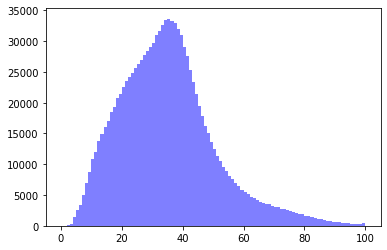

In [0]:
# experiment with the sequence length. Seems like max_seq_len of 50 is enough
df_en['token_count'] = df_en['tokens_x'].apply(lambda x: len(x))
token_count = df_en['token_count'].values

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

num_bins = 100
n, bins, patches = plt.hist(token_count, num_bins, facecolor='blue', alpha=0.5, range=[0,100])
plt.show()

In [0]:
df_en.to_csv(DATA_FOLDER + 'tweets_conversations_en_clean_tokenize.csv', index=False)

### Train / Test Split
Here, we split our data into training and test sets.  For simplicity, we use a random split, which may result in different distributions between the training and test set, but we won't worry about that for this case.

In [0]:
#TODO: split the train & test set
x = df_en['tokens_x']
y = df_en['tokens_y']

all_idx = list(range(len(x)))
train_idx = set(random.sample(all_idx, int(0.8 * len(all_idx))))
test_idx = {idx for idx in all_idx if idx not in train_idx}

train_x = x[list(train_idx)].values
test_x = x[list(test_idx)].values
train_y = y[list(train_idx)].values
test_y = y[list(test_idx)].values

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# TODO: pad all the train/test sequences to a fixed length.
# Hint: use pre padding for x and post padding for y (why?).
# Hint: for x the maxlen should be MAX_MESSAGE_LEN, but for y, it shall be MAX_MESSAGE_LEN+1 because of the special tokens

train_data = pad_sequences(train_x, maxlen=MAX_MESSAGE_LEN, dtype='int32', padding='pre', truncating='pre', value=0.0)
train_label = pad_sequences(train_y, maxlen=MAX_MESSAGE_LEN+1, dtype='int32', padding='post', truncating='post', value=0.0)
test_data = pad_sequences(test_x, maxlen=MAX_MESSAGE_LEN, dtype='int32', padding='pre', truncating='pre', value=0.0)
test_label = pad_sequences(test_y, maxlen=MAX_MESSAGE_LEN+1, dtype='int32', padding='post', truncating='post', value=0.0)

In [0]:
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(922121, 50)
(922121, 51)
(230531, 50)
(230531, 51)


## Model Creation
We'll create and compile the model here.  It will consist of the following components:

- Shared word embeddings
  - A shared embedding layer that turns word indexes (a sparse representation) into a dense/compressed representation.  This embeds both the request from the customer, and also the last words uttered by the model that are fed back into the model.
- Encoder RNN
  - In this case, a single LSTM layer.  This encodes the whole input sentence into a context vector (or thought vector) that represents completely what the customer is saying, and produces a single output.
- Decoder RNN
  - This RNN (also an LSTM in this case) decodes the context vector into a string of tokens/utterances.  For each time step, it takes the context vector and the embedded last utterance and produces the next utterance, which is fed back into the model.  More complex and effective models copy the encoder state into the decoder, add more layers of LSTMs, and apply attention mechanisms - but these are out of the scope of this simple example.
- Next Word Dense+Softmax
  - These two layers take the decoder output and turn it into the next word to be uttered.  The dense layer allows the decoder to not map directly to words uttered, and the softmax turns the dense layer output into a probability distribution, from which we pick the most likely next word.

![seq2seq model structure](https://i.imgur.com/JmuryKu.png)

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, LSTM, Dropout, Embedding, RepeatVector, concatenate, \
    TimeDistributed
from tensorflow.python.keras.utils import np_utils

In [0]:
def create_model():
    # TODO: create a shared embedding with the correct input, output dimension and input length.
    shared_embedding = Embedding(output_dim=EMBEDDING_SIZE,
                                 input_dim=VOCAB_SIZE,
                                 input_length=MAX_MESSAGE_LEN,
                                 name='embedding',)

    # ENCODER
    
    # TODO: create the encoder Input
    encoder_input = Input(shape=(MAX_MESSAGE_LEN,),
                          dtype='int32',
                          name='encoder_input',)
        
    # TODO: the embedded input
    embedded_input = shared_embedding(encoder_input)
    
    # TODO: create the LSTM encoder 
    # Hint: no return_sequences - since the encoder here only produces a single value for the
    # input sequence provided.
    encoder_rnn = LSTM(
        CONTEXT_SIZE,
        name='encoder',
        dropout=DROPOUT
    )
    
    # repeat the context vector.
    context = RepeatVector(MAX_MESSAGE_LEN)(encoder_rnn(embedded_input))
    
    # DECODER
    
    # TODO: create the previous word input.
    last_word_input = Input(shape=(MAX_MESSAGE_LEN, ),
                            dtype='int32',
                            name='last_word_input',)
    
    # TODO: the embedded last word. Note that we use teacher forcing here. 
    # a.k. we use the oracle previous word instead of the generated previous word during training.
    embedded_last_word = shared_embedding(last_word_input)

    # TODO: Concatenate the context produced by the encoder and the last word uttered as inputs
    # to the decoder.
    decoder_input = concatenate([embedded_last_word, context], axis=2)
    
    # TODO: decode the sequence with LSTM
    # return_sequences causes LSTM to produce one output per timestep instead of one at the
    # end of the intput, which is important for sequence producing models.
    decoder_rnn = LSTM(CONTEXT_SIZE,
                       name='decoder',
                       return_sequences=True,
                       dropout=DROPOUT)
    
    decoder_output = decoder_rnn(decoder_input)
    
    # Apply a dense layer
    # Hint: TimeDistributed allows the dense layer to be applied to each decoder output per timestep
    next_word_dense = TimeDistributed(Dense(int(VOCAB_SIZE / 2), activation='relu'),
                                      name='next_word_dense',)(decoder_output)
    
    # Predict the probability of the next word over the whole vocab. 
    # Hint: TimeDistributed allows the softmax layer to be applied to each decoder output per timestep
    next_word = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'),
                                name='next_word_softmax')(next_word_dense)
    
    return Model(inputs=[encoder_input, last_word_input], outputs=[next_word])

s2s_model = create_model()
optimizer = Adam(lr=LEARNING_RATE, clipvalue=5.0)
s2s_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [0]:
s2s_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
last_word_input (InputLayer)    [(None, 50)]         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      524288      encoder_input[0][0]              
                                                                 last_word_input[0][0]            
__________________________________________________________________________________________________
encoder (LSTM)                  (None, 256)          394240      embedding[0][0]              

## Model Training
We'll train the model here.  After each sub-batch of the dataset, we'll test with static input strings to see how the model is progressing in human readable terms.  Its important to have these tests along with traditional model evaluation to provide a better understanding of how well the model is training.

It's important to pull test strings from the real distribution of the data, also.  It can be hard to really put yourself in customers' shoes when writing test messages, and you will get non-representative results when you provide test examples that don't fit the true distribution of the input data (when your input text doesn't sound like real customer requests).

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2036021678029933256
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4832296960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7575339198323864770
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [0]:
!nvidia-smi

Sat Nov 09 15:34:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 436.48       Driver Version: 436.48       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P2    42W /  N/A |   4948MiB /  6144MiB |     16%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Currently, memory growth needs to be the same across GPUs
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
              print(e)

Physical devices cannot be modified after being initialized


In [0]:
def add_start_token(y_array):
    """ Adds the start token to vectors.  Used for training data. """
    return np.hstack([
        START * np.ones((len(y_array), 1)),
        y_array[:, :-1],
    ])

def binarize_labels(labels):
    """ Helper function that turns integer word indexes into sparse binary matrices for 
        the expected model output.
    """
    return np.array([np_utils.to_categorical(row, num_classes=VOCAB_SIZE)
                     for row in labels])

In [0]:
import math
import random
random.seed(42)

def train_genenerator(epochs=20):
    for _ in range(epochs):
        batch_ids = [i for i in range(math.floor(train_data.shape[0]/bs))]
        random.shuffle(batch_ids)
        for i in batch_ids:
            temp_label = train_label[bs*i:bs*i+bs]
            temp_binary_label = binarize_labels(temp_label[:,1:])
            yield [train_data[bs*i:bs*i+bs,:], temp_label[:,:-1]], temp_binary_label

In [0]:
history = s2s_model.fit_generator(train_genenerator(),
                    steps_per_epoch=math.floor(train_data.shape[0]/bs),
                    epochs=1,
                    validation_data=(test_data, test_label),
                    verbose=1)

UnknownError: Fail to find the dnn implementation. [Op:CudnnRNN]

In [0]:
s2s_model.save_weights('models/lstm.h5')

### Test out the model

In [0]:
model = create_model()
model.load_weights('models/lstm.h5')

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def respond_to(model, text):
    """ Helper function that takes a text input and provides a text output. """
    text = text.lower()
    input_y = add_start_token(PAD * np.ones((1, MAX_MESSAGE_LEN)))
    idxs = pad_sequences([sp.EncodeAsIds(str(text))],
                            value=PAD,
                            padding='pre',
                            truncating='post',
                            maxlen=MAX_MESSAGE_LEN)
    for position in range(MAX_MESSAGE_LEN - 1):
        prediction = model.predict([idxs, input_y]).argmax(axis=2)[0]
        input_y[:,position + 1] = prediction[position]
    final_prediction = model.predict([idxs, input_y]).argmax(axis=2)[0]                         
    return sp.decode_ids(final_prediction.tolist())

In [0]:
respond_to(model, '''@Delta I just saw the pretty flight attendent! She is so beautiful''')

In [0]:
respond_to(model, '''@sprintcare I can't make calls... wtf''')

'@__sn__ please send us a direct message, so that we can further assist you. - lp'

In [0]:
respond_to(s2s_model, '''Hi Amazon, Thanks for the fast delivery! I am your loyal customer''')

"@__sn__ you're welcome! ^td"

In [0]:
respond_to(s2s_model, '''Hi there, my macbook keeps hanging, what shall I do?''')

"@__sn__ we'd like to help. dm us the device you're using and we'll get started. <url>"

In [0]:
respond_to(s2s_model, '''Stupid, If you don't refund, I will never use your service again. ''')

"@__sn__ hi, we're sorry to hear this. can you dm us your email address so we can look into this?"

In [0]:
# TODO: Try some interesting queries and see how your chatbot respond.


In [0]:
# Bonus question: try out more sophisticated model instead of the base
# encoder-decoder. You can use attention mechanism or even BERT (it'll be very demanding on the hardware)
